In [64]:
"""
train_xenium_embeddings.py

Loads 2k-matched Xenium spatial + scRNA datasets,
trains:
  - Supervised VAE on reference dataset (B)
  - GNN encoder on spatial dataset (A)
  - MMD alignment loss between the two latent spaces

Outputs:
  - z_ref.npy   (reference latent embeddings)
  - z_spatial.npy (spatial latent embeddings)
  - model weights (vae.pt, gnn.pt)
"""

import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import kneighbors_graph
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import umap

In [65]:
# ---------------------------
# Hyperparameters (tweakable)
# ---------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 20
HIDDEN_DIM = 512
GNN_HIDDEN = 512
BATCH_SIZE = 128
EPOCHS = 120
LR = 1e-3
KL_BETA = 1.0        # final beta for KL (we use warmup)
KL_WARMUP_EPOCHS = 20
LAMBDA_CLF = 5.0     # weight for classification loss on VAE
LAMBDA_MMD = 1.0     # final weight for MMD (we use warmup)
MMD_WARMUP_EPOCHS = 30
USE_SUPCON = False   # set True to enable supervised contrastive loss
SUPCON_WEIGHT = 1.0
SUPCON_TEMP = 0.1
KNN_K = 6           # for spatial graph
SEED = 42
RNG = np.random.default_rng(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [66]:
# ---------------------------
# Utility functions
# ---------------------------
def pairwise_distances(x, y):
    x_norm = (x**2).sum(dim=1).view(-1,1)
    y_norm = (y**2).sum(dim=1).view(1,-1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y.t())
    return torch.clamp(dist, min=0.0)

def gaussian_kernel(x, y, sigma):
    dist = pairwise_distances(x, y)
    return torch.exp(-dist / (2.0 * sigma**2))

def mmd_rbf(x, y, sigmas=(0.5,1.0,2.0,4.0)):
    Kxx = 0.0; Kyy = 0.0; Kxy = 0.0
    for s in sigmas:
        Kxx += gaussian_kernel(x, x, s).mean()
        Kyy += gaussian_kernel(y, y, s).mean()
        Kxy += gaussian_kernel(x, y, s).mean()
    return Kxx + Kyy - 2.0*Kxy

def supcon_loss(features, labels, temperature=0.1, eps=1e-8):
    # features: (B, D), labels: (B,)
    features = nn.functional.normalize(features, dim=1)
    logits = torch.div(torch.matmul(features, features.t()), temperature)
    logits_max, _ = torch.max(logits, dim=1, keepdim=True)
    logits = logits - logits_max.detach()
    labels = labels.contiguous().view(-1,1)
    mask = torch.eq(labels, labels.t()).float().to(features.device)
    logits_mask = torch.ones_like(mask) - torch.eye(mask.size(0), device=mask.device)
    mask = mask * logits_mask
    exp_logits = torch.exp(logits) * logits_mask
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + eps)
    mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + eps)
    loss = - mean_log_prob_pos.mean()
    return loss

In [67]:
# ---------------------------
# Models
# ---------------------------
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
        )
        self.mu = nn.Linear(hidden_dim//2, latent_dim)
        self.logvar = nn.Linear(hidden_dim//2, latent_dim)
        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim//2),
            nn.ReLU(),
            nn.Linear(latent_dim//2, 1)  # we'll adapt to multiclass later by using BCE or linear + CE externally
        )
        # decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, input_dim)
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        recon = self.decode(z)
        # classifier head will be applied externally as a Linear mapping for multiclass
        return recon, mu, logvar, z

class GNNEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, input_dim)
        )
    def forward(self, X, A_norm):
        H = torch.relu(A_norm @ self.lin1(X))
        Z = A_norm @ self.lin2(H)
        recon = self.dec(Z)
        return recon, Z


In [68]:
# ---------------------------
# Data loading & preprocessing
# ---------------------------
def load_and_preprocess(ref_path="SmallData/xenium_reference_common_genes.h5ad",
                        spat_path="SmallData/xenium_spatial_common_genes.h5ad"):
    # load
    B = sc.read_h5ad(ref_path)
    A = sc.read_h5ad(spat_path)

    # Prefer obs column with broad labels (user should have created 'broad_cell_type' earlier)
    possible_ref_cols = ["broad_cell_type", "celltype_major", "celltype", "cell_type"]
    ref_label_col = next((c for c in possible_ref_cols if c in B.obs.columns), None)
    possible_spat_cols = ["broad_cell_type", "cell_type", "predicted_label"]
    spat_label_col = next((c for c in possible_spat_cols if c in A.obs.columns), None)

    if ref_label_col is None:
        raise RuntimeError("Reference label column not found. Set 'broad_cell_type' or similar in B.obs.")
    if spat_label_col is None:
        print("Warning: spatial label column not found. Spatial labels will be None (can't compute test acc).")

    # Normalize total and log1p (inplace on copies)
    Bc = B.copy()
    Ac = A.copy()
    sc.pp.normalize_total(Bc, target_sum=1e4)
    sc.pp.log1p(Bc)
    sc.pp.normalize_total(Ac, target_sum=1e4)
    sc.pp.log1p(Ac)

    # Convert to dense arrays (small 2k dataset assumed)
    X_ref = Bc.X.toarray() if hasattr(Bc.X, "toarray") else Bc.X
    X_spat = Ac.X.toarray() if hasattr(Ac.X, "toarray") else Ac.X

    # labels
    y_ref = Bc.obs[ref_label_col].astype(str).values
    y_spat = Ac.obs[spat_label_col].astype(str).values if spat_label_col in Ac.obs.columns else None

    # map labels to ints
    all_labels = np.unique(np.concatenate([y_ref] + ([y_spat] if y_spat is not None else [])))
    label_to_id = {lab: i for i, lab in enumerate(all_labels)}
    y_ref_id = np.array([label_to_id[l] for l in y_ref])
    y_spat_id = np.array([label_to_id[l] for l in y_spat]) if y_spat is not None else None

    # spatial coords
    if "spatial" not in Ac.obsm_keys():
        raise RuntimeError("Spatial coords key 'spatial' not found in A.obsm.")
    coords = Ac.obsm["spatial"]

    return (X_ref.astype(np.float32), y_ref_id, Bc.obs_names.values, label_to_id,
            X_spat.astype(np.float32), y_spat_id, Ac.obs_names.values, coords, all_labels)


In [69]:
# ---------------------------
# Build normalized adjacency
# ---------------------------
def build_adj(coords, k=KNN_K):
    A = kneighbors_graph(coords, n_neighbors=k, mode="connectivity", include_self=True).toarray().astype(float)
    A = (A + A.T) / 2.0
    A += np.eye(A.shape[0])
    deg = A.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg + 1e-8))
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_norm, dtype=torch.float32, device=DEVICE)


In [70]:
# ---------------------------
# Training loop
# ---------------------------
def train():
    (X_ref, y_ref, ref_ids, label_to_id,
     X_spat, y_spat, spat_ids, coords, all_labels) = load_and_preprocess(
         ref_path="SmallData/xenium_reference_common_genes.h5ad",
         spat_path="SmallData/xenium_spatial_common_genes.h5ad"
    )

    N_ref, G = X_ref.shape
    N_spat = X_spat.shape[0]

    # pytorch tensors
    X_ref_t = torch.tensor(X_ref, dtype=torch.float32, device=DEVICE)
    X_spat_t = torch.tensor(X_spat, dtype=torch.float32, device=DEVICE)
    y_ref_t = torch.tensor(y_ref, dtype=torch.long, device=DEVICE)

    # models
    vae = SupervisedVAE(input_dim=G, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM).to(DEVICE)
    # We'll add an external classifier linear layer (multiclass) on top of z
    clf_head = nn.Linear(LATENT_DIM, len(all_labels)).to(DEVICE)
    gnn = GNNEncoder(input_dim=G, latent_dim=LATENT_DIM, hidden_dim=GNN_HIDDEN).to(DEVICE)

    opt = optim.Adam(list(vae.parameters()) + list(clf_head.parameters()) + list(gnn.parameters()), lr=LR, weight_decay=1e-5)
    mse = nn.MSELoss(reduction="mean")
    ce = nn.CrossEntropyLoss()

    # adjacency
    A_norm = build_adj(coords, k=KNN_K)

    # dataloader for reference
    ref_loader = DataLoader(TensorDataset(X_ref_t, y_ref_t), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

    history = {"recon":[], "kl":[], "ce":[], "mmd":[], "train_acc":[]}

    for ep in range(1, EPOCHS+1):
        vae.train(); gnn.train(); clf_head.train()
        epoch_recon = epoch_kl = epoch_ce = epoch_mmd = 0.0
        total = 0

        # schedules
        kl_factor = min(1.0, ep / max(1, KL_WARMUP_EPOCHS)) * KL_BETA
        mmd_factor = min(1.0, ep / max(1, MMD_WARMUP_EPOCHS)) * LAMBDA_MMD

        for xb, yb in ref_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)

            # ---- VAE forward (supervised) ----
            recon_b, mu_b, logvar_b, z_b = vae(xb)
            recon_loss = mse(recon_b, xb)
            kl = -0.5 * torch.mean(1 + logvar_b - mu_b.pow(2) - logvar_b.exp())
            # classifier loss
            logits = clf_head(z_b)
            clf_loss = ce(logits, yb)

            # supervised-contrastive (optional)
            supcon = torch.tensor(0.0, device=DEVICE)
            if USE_SUPCON:
                supcon = supcon_loss(z_b, yb, temperature=SUPCON_TEMP)

            # ---- GNN forward (full-batch) ----
            recon_a, z_a = gnn(X_spat_t, A_norm)
            recon_loss_gnn = mse(recon_a, X_spat_t)

            # sample subset from z_a for MMD (match ref batch size or max 256)
            sample_k = min(z_a.shape[0], xb.shape[0])
            idx = np.random.choice(z_a.shape[0], size=sample_k, replace=False)
            z_a_sub = z_a[idx]

            # standardize z before MMD (empirical)
            zb_std = (z_b - z_b.mean(0)) / (z_b.std(0) + 1e-8)
            za_std = (z_a_sub - z_a_sub.mean(0)) / (z_a_sub.std(0) + 1e-8)

            mmd_loss = mmd_rbf(zb_std, za_std)

            loss = recon_loss + kl_factor * kl + LAMBDA_CLF * clf_loss + (SUPCON_WEIGHT * supcon if USE_SUPCON else 0.0) \
                   + recon_loss_gnn + mmd_factor * mmd_loss

            opt.zero_grad()
            loss.backward()
            opt.step()

            bs = xb.size(0)
            epoch_recon += recon_loss.item() * bs
            epoch_kl += kl.item() * bs
            epoch_ce += clf_loss.item() * bs
            epoch_mmd += mmd_loss.item() * bs
            total += bs

        # epoch statistics
        epoch_recon /= total
        epoch_kl /= total
        epoch_ce /= total
        epoch_mmd /= total

        # compute training accuracy on full reference embeddings (fast)
        vae.eval(); gnn.eval(); clf_head.eval()
        with torch.no_grad():
            _, _, _, z_ref_full = vae(X_ref_t)
            logits_all = clf_head(z_ref_full)
            preds = torch.argmax(logits_all, dim=1).cpu().numpy()
            train_acc = accuracy_score(y_ref, preds)

        history["recon"].append(epoch_recon)
        history["kl"].append(epoch_kl)
        history["ce"].append(epoch_ce)
        history["mmd"].append(epoch_mmd)
        history["train_acc"].append(train_acc)

        if ep % max(1, EPOCHS//10) == 0 or ep==1:
            print(f"[{ep:03d}/{EPOCHS}] recon={epoch_recon:.4f} kl={epoch_kl:.4f} ce={epoch_ce:.4f} mmd={epoch_mmd:.4f} kl_factor={kl_factor:.3f} mmd_factor={mmd_factor:.3f} train_acc={train_acc:.4f}")

    # Save final embeddings and models
    with torch.no_grad():
        _, _, _, z_ref_final = vae(X_ref_t)
        _, z_spat_final = gnn(X_spat_t, A_norm)

    np.save("Results/z_ref.npy", z_ref_final.cpu().numpy())
    np.save("Results/z_spatial.npy", z_spat_final.cpu().numpy())
    torch.save(vae.state_dict(), "Results/vae_supervised.pt")
    torch.save(clf_head.state_dict(), "Results/clf_head.pt")
    torch.save(gnn.state_dict(), "Results/gnn.pt")
    np.save("Results/training_history.npy", np.array([history["recon"], history["kl"], history["ce"], history["mmd"], history["train_acc"]], dtype=object))

    print("Saved models and embeddings.")

    # Visualize embeddings (UMAP)
    Z = np.vstack([z_ref_final.cpu().numpy(), z_spat_final.cpu().numpy()])
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=SEED)
    Z2 = reducer.fit_transform(Z)
    nref = z_ref_final.shape[0]

    plt.figure(figsize=(8,6))
    plt.scatter(Z2[:nref,0], Z2[:nref,1], c="tab:blue", s=6, cmap="tab10", alpha=0.6, label="ref")
    plt.scatter(Z2[nref:,0], Z2[nref:,1], c="tab:orange", s=6, cmap="tab10", alpha=0.6, label="spat")
    plt.title("UMAP of learned latents (ref:colored by label, spat:colored by label if present)")
    plt.legend()
    plt.savefig("Plots/umap_learned_latents.png", dpi=200)
    plt.show()

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


[001/120] recon=2.8636 kl=1.8927 ce=1.2436 mmd=0.2592 kl_factor=0.050 mmd_factor=0.033 train_acc=0.8785
[012/120] recon=1.8115 kl=1.2540 ce=0.0560 mmd=0.0933 kl_factor=0.600 mmd_factor=0.400 train_acc=1.0000
[024/120] recon=1.7940 kl=0.7673 ce=0.0442 mmd=0.0688 kl_factor=1.000 mmd_factor=0.800 train_acc=1.0000
[036/120] recon=1.7736 kl=0.6585 ce=0.0324 mmd=0.0637 kl_factor=1.000 mmd_factor=1.000 train_acc=1.0000
[048/120] recon=1.7548 kl=0.6051 ce=0.0258 mmd=0.0617 kl_factor=1.000 mmd_factor=1.000 train_acc=1.0000
[060/120] recon=1.7342 kl=0.5840 ce=0.0223 mmd=0.0609 kl_factor=1.000 mmd_factor=1.000 train_acc=1.0000
[072/120] recon=1.7269 kl=0.5663 ce=0.0205 mmd=0.0606 kl_factor=1.000 mmd_factor=1.000 train_acc=0.9995
[084/120] recon=1.7069 kl=0.5477 ce=0.0194 mmd=0.0593 kl_factor=1.000 mmd_factor=1.000 train_acc=0.9985
[096/120] recon=1.7101 kl=0.5320 ce=0.0165 mmd=0.0589 kl_factor=1.000 mmd_factor=1.000 train_acc=0.9990
[108/120] recon=1.6900 kl=0.5259 ce=0.0151 mmd=0.0590 kl_factor=

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/b3/hhpkbnjn3tsgdz2s3hjt3rdw0000gn/T/ipykernel_75422/814799031.py:135: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z2[:nref,0], Z2[:nref,1], c="tab:blue", s=6, cmap="tab10", alpha=0.6, label="ref")
/var/folders/b3/hhpkbnjn3tsgdz2s3hjt3rdw0000gn/T/ipykernel_75422/814799031.py:136: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Z2[nref:,0], Z2[nref:,1], c="tab:orange", s=6, cmap="tab10", alpha=0.6, label="spat")


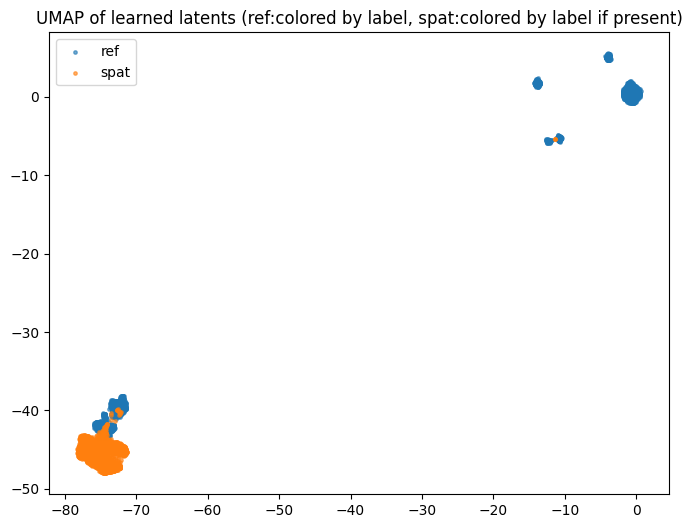

In [71]:
train()

Saved spatial embeddings to Results/z_spatial_from_gnn.npy (shape (2000, 20))


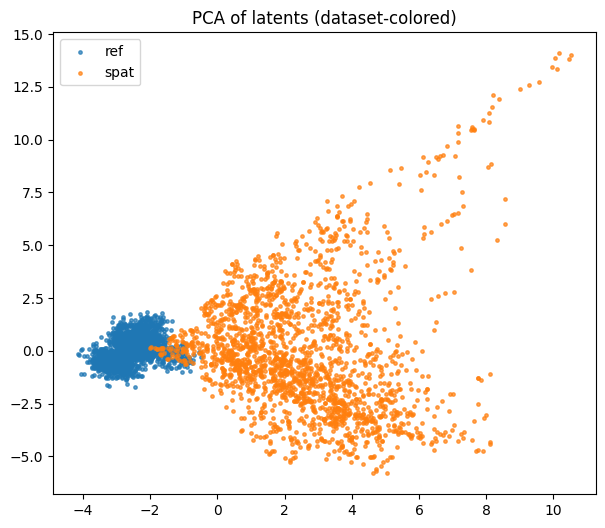

/Users/zehaannaik/Course Work/SEM-7/CS690/Xenium_Annotation_CS690/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


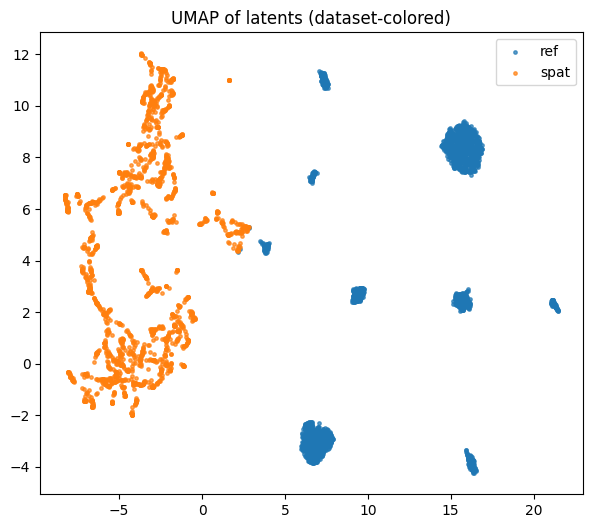

In [74]:
# compute_spatial_embeddings.py
import numpy as np
import scanpy as sc
import torch
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- User-editable paths ---
GNN_MODEL_PATH = "Results/gnn.pt"                   # your saved GNN state dict
SPAT_H5AD = "SmallData/xenium_spatial_common_genes.h5ad"   # preprocessed (same preprocessing as training)
REF_Z_PATH = "Results/z_ref.npy"                    # reference embeddings (trained VAE)
OUT_Z_SPAT = "Results/z_spatial_from_gnn.npy"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Model definition (must match architecture used to train) ---
import torch.nn as nn
class GNNEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, latent_dim)
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, input_dim)
        )
    def forward(self, X, A_norm):
        H = torch.relu(A_norm @ self.lin1(X))
        Z = A_norm @ self.lin2(H)
        recon = self.dec(Z)
        return recon, Z

# --- Utility: build adjacency exactly like training did ---
from sklearn.neighbors import kneighbors_graph
def build_A_norm(coords, k=12):
    A = kneighbors_graph(coords, n_neighbors=k, mode="connectivity", include_self=True).toarray().astype(float)
    A = (A + A.T) / 2.0
    A += np.eye(A.shape[0])
    deg = A.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg + 1e-8))
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt
    return A_norm

# --- Load spatial AnnData and preprocessing must match training pipeline ---
adata = sc.read_h5ad(SPAT_H5AD)
# If you normalized when training (normalize_total + log1p), ensure same here:
# e.g., if the file saved already has that preprocessing applied, skip.
# Otherwise:
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

X_spat = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
coords = adata.obsm["spatial"]

# --- instantiate model with correct dims ---
input_dim = X_spat.shape[1]
latent_dim = 20   # set to whatever you trained with
hidden_dim = 512  # same as training

gnn = GNNEncoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(DEVICE)
gnn.load_state_dict(torch.load(GNN_MODEL_PATH, map_location=DEVICE))
gnn.eval()

# --- build adjacency and convert to torch tensors ---
A_norm = build_A_norm(coords, k=12)
A_norm_t = torch.tensor(A_norm, dtype=torch.float32, device=DEVICE)

# --- forward pass (full-batch) to get z_spat ---
X_spat_t = torch.tensor(X_spat.astype(np.float32), dtype=torch.float32, device=DEVICE)
with torch.no_grad():
    _, z_spat_t = gnn(X_spat_t, A_norm_t)

z_spat = z_spat_t.cpu().numpy()
np.save(OUT_Z_SPAT, z_spat)
print(f"Saved spatial embeddings to {OUT_Z_SPAT} (shape {z_spat.shape})")

# --- Visualization: compare z_ref and z_spat colored by dataset only ---
z_ref = np.load(REF_Z_PATH)   # make sure this uses the same latent_dim & preprocessing

# Optional: standardize both before visualizing (recommended)
scaler = StandardScaler()
Z_all = np.vstack([z_ref, z_spat])
Z_all_scaled = scaler.fit_transform(Z_all)
n_ref = z_ref.shape[0]

# PCA
pca = PCA(n_components=2)
Zp = pca.fit_transform(Z_all_scaled)
plt.figure(figsize=(7,6))
plt.scatter(Zp[:n_ref,0], Zp[:n_ref,1], s=6, alpha=0.7, c='tab:blue', label='ref')
plt.scatter(Zp[n_ref:,0], Zp[n_ref:,1], s=6, alpha=0.7, c='tab:orange', label='spat')
plt.legend()
plt.title("PCA of latents (dataset-colored)")
plt.savefig("latents_dataset_pca.png", dpi=180)
plt.show()

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
Zu = reducer.fit_transform(Z_all_scaled)
plt.figure(figsize=(7,6))
plt.scatter(Zu[:n_ref,0], Zu[:n_ref,1], s=6, alpha=0.7, c='tab:blue', label='ref')
plt.scatter(Zu[n_ref:,0], Zu[n_ref:,1], s=6, alpha=0.7, c='tab:orange', label='spat')
plt.legend()
plt.title("UMAP of latents (dataset-colored)")
plt.savefig("latents_dataset_umap.png", dpi=180)
plt.show()
